In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ../src

/home/theo/kaggle/birds/src


In [3]:
import re
import gc
import os
import time
import random
import operator
import datetime
import soundfile
import numpy as np
import pandas as pd
import seaborn as sns
import IPython.display as ipd
import matplotlib.pyplot as plt

from sklearn.metrics import *
from collections import Counter
from tqdm.notebook import tqdm
from scipy.special import softmax
from scipy.io.wavfile import write
from audiomentations import Resample
from sklearn.model_selection import *

In [4]:
from params import *

## Np check

In [5]:
import numpy as np

n = 100

a = np.random.rand(128, n)
b = np.random.rand(n, 1594)

%time c = np.dot(a, b)

CPU times: user 2.03 ms, sys: 1.2 ms, total: 3.24 ms
Wall time: 2.85 ms


## extra audios

In [6]:
df_extra = pd.read_csv(DATA_PATH + "train_extended.csv")

In [7]:
paths = []
for c, file in df_extra[["ebird_code", "filename"]].values:
    path = f"{c}/{file[:-4]}.wav"
    paths.append(path)
    
df_extra['file_path'] = paths

In [8]:
df_train.columns, df_extra.columns

NameError: name 'df_train' is not defined

In [ ]:
len(df_train), len(df_extra)

In [21]:
cat = pd.concat((df_train, df_extra), 0).reset_index(drop=True)

In [25]:

df_train = pd.read_csv(DATA_PATH + "train.csv")

paths = []
for c, file in df_train[["ebird_code", "filename"]].values:
    path = f"{c}/{file[:-4]}.wav"
    paths.append(path)

df_train["file_path"] = paths

## dataset

In [28]:
df_train = pd.read_csv(DATA_PATH + "train.csv")

paths = []
for c, file in df_train[["ebird_code", "filename"]].values:
    path = f"{AUDIO_PATH}{c}/{file[:-4]}.wav"
    paths.append(path)
df_train["file_path"] = paths

In [29]:
df_train.head()

rating playback_used ebird_code    channels        date          pitch  \
0     3.5            no     aldfly    1 (mono)  2013-05-25  Not specified   
1     4.0            no     aldfly  2 (stereo)  2013-05-27           both   
2     4.0            no     aldfly  2 (stereo)  2013-05-27           both   
3     3.5            no     aldfly  2 (stereo)  2013-05-27           both   
4     4.0            no     aldfly  2 (stereo)  2013-05-27           both   

   duration      filename          speed           species  ...  \
0        25  XC134874.mp3  Not specified  Alder Flycatcher  ...   
1        36  XC135454.mp3           both  Alder Flycatcher  ...   
2        39  XC135455.mp3           both  Alder Flycatcher  ...   
3        33  XC135456.mp3           both  Alder Flycatcher  ...   
4        36  XC135457.mp3          level  Alder Flycatcher  ...   

                                 url        country            author  \
0  https://www.xeno-canto.org/134874  United States  Jonathon Jongsma   
1  https://www.xeno-canto.org/135454  United States       Mike Nelson   
2  https://www.xeno-canto.org/135455  United States       Mike Nelson   
3  https://www.xeno-canto.org/135456  United States       Mike Nelson   
4  https://www.xeno-canto.org/135457  United States       Mike Nelson   

                        primary_label longitude         length   time  \
0  Empidonax alnorum_Alder Flycatcher   -92.962  Not specified   8:00   
1  Empidonax alnorum_Alder Flycatcher  -82.1106         0-3(s)  08:30   
2  Empidonax alnorum_Alder Flycatcher  -82.1106         0-3(s)  08:30   
3  Empidonax alnorum_Alder Flycatcher  -82.1106         0-3(s)  08:30   
4  Empidonax alnorum_Alder Flycatcher  -82.1106         0-3(s)  08:30   

          recordist                                            license  \
0  Jonathon Jongsma        Creative Commons Attribution-ShareAlike 3.0   
1       Mike Nelson  Creative Commons Attribution-NonCommercial-Sha...   
2       Mike Nelson  Creative Commons Attribution-NonCommercial-Sha...   
3       Mike Nelson  Creative Commons Attribution-NonCommercial-Sha...   
4       Mike Nelson  Creative Commons Attribution-NonCommercial-Sha...   

                                 file_path  
0  ../../../data/audio/aldfly/XC134874.wav  
1  ../../../data/audio/aldfly/XC135454.wav  
2  ../../../data/audio/aldfly/XC135455.wav  
3  ../../../data/audio/aldfly/XC135456.wav  
4  ../../../data/audio/aldfly/XC135457.wav  

[5 rows x 36 columns]

In [32]:
from data.dataset import *

In [33]:
class AudioParams:
    sr = 32000
    duration = 5
    img_size = None

    # Melspectrogram
    n_mels = 128
    fmin = 20
    fmax = 16000

    # n_fft = n_mels * 20 # Size of fft window - smooths the spectrogram
    n_fft = 1024

    spec_width = 384
    hop_length = duration * sr // spec_width + 1  # Computed to have width=spec_width
    # hop_length = 512

In [38]:
d = BirdDataset(df_train.sample(int(len(df_train) * 0.8)), AudioParams)

In [ ]:
for i in tqdm(range(len(d))):
    _ = d[i]

In [35]:
d[0]

(array([[[0.57254905, 0.53333336, 0.53333336, ..., 0.4862745 ,
          0.54509807, 0.49803922],
         [0.54509807, 0.5137255 , 0.47843137, ..., 0.54509807,
          0.5411765 , 0.5529412 ],
         [0.49411765, 0.54509807, 0.53333336, ..., 0.5176471 ,
          0.49803922, 0.5019608 ],
         ...,
         [0.01176471, 0.        , 0.        , ..., 0.        ,
          0.        , 0.09803922],
         [0.01176471, 0.        , 0.        , ..., 0.        ,
          0.        , 0.09803922],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.08627451]],
 
        [[0.57254905, 0.53333336, 0.53333336, ..., 0.4862745 ,
          0.54509807, 0.49803922],
         [0.54509807, 0.5137255 , 0.47843137, ..., 0.54509807,
          0.5411765 , 0.5529412 ],
         [0.49411765, 0.54509807, 0.53333336, ..., 0.5176471 ,
          0.49803922, 0.5019608 ],
         ...,
         [0.01176471, 0.        , 0.        , ..., 0.        ,
          0.        , 0.

## clamp

In [21]:
path = AUDIO_PATH + 'bkbcuc/XC152413.wav'
# path = 'XC134874.wav'

In [ ]:
%%timeit
y, sr = soundfile.read(path)

In [18]:
np.save('test.npy', y)

In [19]:
%%timeit
y = np.load('test.npy')

302 µs ± 9.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [16]:
%%timeit
y = np.load('test.npy')

304 µs ± 14.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [14]:
import librosa 

def load_audio(path, sr=32000):
    clip, _ = librosa.load(path, sr=sr, mono=True, res_type="kaiser_fast")
    return clip

In [21]:
%%timeit
y = load_audio(path, sr=32000)

404 µs ± 8.33 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [22]:
%%timeit
y2, sr = soundfile.read(path)

302 µs ± 17.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## loading audios

In [287]:
# y, sr = torchaudio.load(AUDIO_PATH + '/purfin/XC156529.wav')

In [ ]:
y, sr = soundfile.read(self.audio_path + self.paths[idx])

## specaug

In [277]:
from training.specaugment import *

In [268]:
spec_augmenter = SpecAugmentation(
    time_drop_width=16, time_stripes_num=2, freq_drop_width=8, freq_stripes_num=2
)


In [269]:
x = torch.ones(1, 3, 200, 300)

In [270]:
y = spec_augmenter(x)

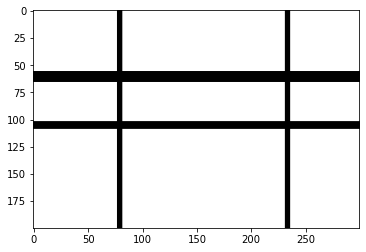

In [271]:
plt.imshow(x[0].numpy().transpose(1, 2, 0))

## inception v3

In [88]:
import torchvision.models as models

In [89]:
model = models.inception_v3(pretrained=True)

In [90]:
299

299

In [91]:
x = torch.randn(8, 3, 384, 313)

In [92]:
y = model(x)

### wav augments

In [239]:
import pysndfx

In [240]:
path = AUDIO_PATH + 'bkbcuc/' + 'XC322763.wav'

In [241]:
y, sr = soundfile.read(path)

In [242]:
y = y [sr : sr*6]

In [243]:
ipd.Audio(y, rate=sr)

In [244]:
from data.transforms import AudioAugmentation

In [250]:
aug = AudioAugmentation(p_effects=1)

In [251]:
# idx = np.random.choice(path)
y_aug = aug(y, sr)
ipd.Audio(y_aug, rate=sr)

## sample

In [285]:
from scipy.special import softmax

In [286]:
x = np.random.random(10)
# x = x 

In [287]:
x 

array([0.52636432, 0.38266145, 0.52473597, 0.00338882, 0.56989077,
       0.63553096, 0.26131531, 0.83591728, 0.0090396 , 0.8383109 ])

In [288]:
x1 = x / np.sum(x)

x2 = x ** 5
x2 = x2 / np.sum(x2)

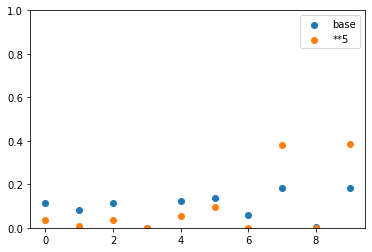

In [290]:
plt.scatter(range(len(x)), x1, label='base')
plt.scatter(range(len(x)), x2, label='**5')
plt.legend()
plt.ylim(0, 1)
plt.show()

## norm

In [213]:
def resize_and_transpose(image, size):
    if size is not None:
        h, w, _ = image.shape
        new_w, new_h = int(w * size / h), size
        image = cv2.resize(image, (new_w, new_h))
        
    image = np.moveaxis(image, 2, 0)
    
    return (image / 255.0).astype(np.float32)


def mono_to_color(X: np.ndarray, mean=None, std=None, norm_max=None, norm_min=None, eps=1e-6):
    """
    Code from https://www.kaggle.com/daisukelab/creating-fat2019-preprocessed-data
    """
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)
    
    # Normalize to [0, 255]
    _min, _max = X.min(), X.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    
    if (_max - _min) > eps:
        V = np.clip(X, norm_min, norm_max)
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        # Just zero
        V = np.zeros_like(X, dtype=np.uint8)
    return V



In [207]:
def mono_to_color2(X, eps=1e-6):
    X = np.stack([X, X, X], axis=-1)

    # Normalize to [0, 255]
    _min, _max = X.min(), X.max()

    if (_max - _min) > eps:
        V = np.clip(X, _min, _max)
        V = 255 * (V - _min) / (_max - _min)
        V = V.astype(np.uint8)
    else:
        V = np.zeros_like(X, dtype=np.uint8)

    return V


def resize(image, size=None):
    if size is not None:
        h, w, _ = image.shape
        new_w, new_h = int(w * size / h), size
        # image = cv2.resize(image, (new_w, new_h))

    return image


def normalize(image, mean=None, std=None):
    image = image / 255.0
    if mean is not None and std is not None:
        image = (image - mean) / std
    return np.moveaxis(image, 2, 0).astype(np.float32)

In [220]:
melspec = np.random.random((100, 100)) * 100
melspec = np.zeros((100, 100)) * 100


image = mono_to_color2(melspec)
image = resize(image, None)
image = normalize(image, mean=None, std=None)

image_ = mono_to_color(melspec)
image_ = resize(image_, None)
image_ = normalize(image_, mean=None, std=None)

In [221]:
image.shape

(3, 100, 100)

In [222]:
(image == image_).all()

True

In [206]:
for i in range(1):
    X = np.zeros((1, 100, 100))
#     X = np.random.random((1, 100, 100))
    y2 = mono_to_color2(X)
    y = mono_to_color(X)
    
    print((y == y2).all())
#     if not (y == y2).all():
#         print(X)
        
    break

True


### effnet

In [185]:
from efficientnet_pytorch import EfficientNet

In [179]:
model = EfficientNet.from_pretrained("efficientnet-b0", {"image_size": 256, "include_top": False})

Loaded pretrained weights for efficientnet-b0


In [173]:
x = torch.randn(1, 3, 128, 128)

In [176]:
y = model(x)

In [178]:
y.size()

torch.Size([1, 1000])

In [160]:
# model._global_params.include_top = False

AttributeError: can't set attribute

## Normalize

In [130]:
from data.transforms import *

In [131]:
X = (np.random.random((100, 100)) * 2 - 1) * 10

In [132]:
X.shape

(100, 100)

In [133]:
X.min()

-9.990616298773634

In [134]:
X = mono_to_color(X)

In [135]:
X.shape

(100, 100, 3)

In [136]:
X = resize(X)

In [137]:
X.shape

(100, 100, 3)

In [138]:
X.mean(0).mean(0) / 255

array([0.49755137, 0.49755137, 0.49755137])

In [139]:
X = normalize(X, MEAN, STD)

In [143]:
X.mean(-1).mean(-1) * STD + MEAN

array([0.49755138, 0.49755138, 0.49755138])

## Mixup distribution

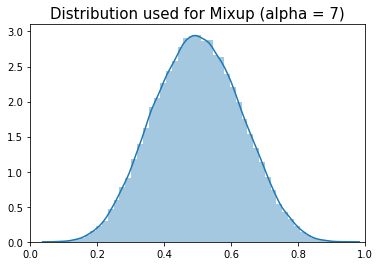

In [329]:
alpha_ = 7
sns.distplot(np.random.beta(alpha_, alpha_, 100000))
plt.xlim(0, 1)
plt.title(f'Distribution used for Mixup (alpha = {alpha_})', size=15)
plt.show()

## Background data

In [330]:
background_data = pd.read_csv(DATA_PATH + "ff1010bird_metadata_2018.csv")
background_data = background_data[background_data['hasbird'] == 0]

In [331]:
idx = np.random.choice(background_data['itemid'])
y, sr = soundfile.read("../../../data/wav/" + str(idx) + ".wav")

print(idx)
ipd.Audio(y, rate=sr)

139095


In [290]:
resample = Resample(min_sample_rate=32000, max_sample_rate=32000, p=1)

for path in os.listdir(BACKGROUND_PATH):
    y, sr = soundfile.read(BACKGROUND_PATH + path)

    if sr != 32000:
        y_r = resample(samples=y, sample_rate=sr)
        write(BACKGROUND_PATH + path, 32000, y_r)
        
        print(f'Resampled {path}')

NameError: name 'Resample' is not defined

In [341]:
p = np.random.choice(os.listdir(BACKGROUND_PATH))
y, sr = soundfile.read(BACKGROUND_PATH + p)
print(p)
ipd.Audio(y, rate=sr)

ORANGE_301.0_304.8.wav


## Test examples

In [312]:
ex1_path = DATA_PATH + "example_test_audio/ORANGE-7-CAP_20190606_093000.pt623.wav"
ex2_path = DATA_PATH + "example_test_audio/BLKFR-10-CPL_20190611_093000.pt540.wav"

In [313]:
check_path = "../output/ORANGE_184.8_189.6.wav"

In [320]:
y, sr = soundfile.read(check_path)

In [322]:
sr

32000

In [323]:
ipd.Audio(y, rate=sr)

In [302]:
lapse = 0 + np.array([0, 20])
lapse

array([ 0, 20])

In [303]:
ipd.Audio(y[int(lapse[0] * sr) : int(lapse[1] * sr), 0], rate=sr)

In [315]:
# ORANGE-7-CAP_20190606_093000.pt623.wav
lapses = [
    [10.1, 13.5],
    [27, 31],
    [47, 50.5],
    [52, 55],
    [58, 61],
    [120.5, 124. ],
    [160.5, 167. ],
    [184.8, 189.6],
    [196.5, 199.5],
    [204.2, 209.2],
    [236.2, 240.7],
    [243.2, 247.2], 
    [263.2, 267. ],
    [301. , 304.8],
]

In [318]:
# BLKFR-10-CPL_20190611_093000.pt540.wav
lapses = [
    [88.7, 93.2],
    [122, 128],
    [149, 157],
    [156, 163],
    [162, 168],
    [183.2, 188.2],
    [189.5, 193.5],
    [197, 203]
]

### Saving

In [319]:
resample = Resample(min_sample_rate=32000, max_sample_rate=32000, p=1)

for lapse in lapses:
    sample = y[int(lapse[0] * sr) : int(lapse[1] * sr), 0]
    if lapse[1] - lapse[0] < 5:
        sample = np.concatenate((sample, sample[::-1]))
        
    if sr != 32000:
        sample = resample(samples=sample, sample_rate=sr)

    write(f"../output/BLKFR_{lapse[0]}_{lapse[1]}.wav", 32000, sample)

In [332]:
os.listdir(BACKGROUND_PATH)

['ORANGE_204.2_209.2.wav',
 'ORANGE_236.2_240.7.wav',
 '189862.wav',
 'ORANGE_120.5_124.0.wav',
 'BLKFR_189.5_193.5.wav',
 'BLKFR_122_128.wav',
 'BLKFR_162_168.wav',
 'ORANGE_27_31.wav',
 'ORANGE_243.2_247.2.wav',
 'ORANGE_52_55.wav',
 'ORANGE_184.8_189.6.wav',
 'ORANGE_58_61.wav',
 '73254.wav',
 'ORANGE_301.0_304.8.wav',
 'BLKFR_183.2_188.2.wav',
 'BLKFR_156_163.wav',
 'ORANGE_160.5_167.0.wav',
 'BLKFR_149_157.wav',
 '54539.wav',
 '141977.wav',
 'ORANGE_196.5_199.5.wav',
 '65252.wav',
 '52114.wav',
 'ORANGE_10.1_13.5.wav',
 'ORANGE_47_50.5.wav',
 '90345.wav',
 '102090.wav',
 '187090.wav',
 'BLKFR_197_203.wav',
 'ORANGE_263.2_267.0.wav',
 '72222.wav',
 'BLKFR_88.7_93.2.wav']

## loading times

In [342]:
df_train = pd.read_csv(DATA_PATH + 'train.csv')

In [346]:
df_train[df_train['duration'] > 500]

rating playback_used ebird_code    channels        date          pitch  \
824       2.5            no     amewoo    1 (mono)  2011-05-25  Not specified   
825       3.5            no     amewoo    1 (mono)  2011-05-28  Not specified   
839       3.5            no     amewoo  2 (stereo)  2016-05-14          level   
877       3.5            no     amtspa    1 (mono)  2013-03-31  Not specified   
1340      5.0           NaN     banswa  2 (stereo)  2013-06-24  Not specified   
...       ...           ...        ...         ...         ...            ...   
18976     5.0            no      veery    1 (mono)  2019-05-25  Not specified   
19081     5.0            no     vesspa    1 (mono)  2019-06-11  Not specified   
19082     5.0            no     vesspa    1 (mono)  2019-06-11  Not specified   
20382     3.5            no    winwre3    1 (mono)  2014-11-10  Not specified   
20688     4.5            no     woothr    1 (mono)  2014-05-10  Not specified   

       duration      filename          speed                species  ...  \
824         554  XC305896.mp3  Not specified      American Woodcock  ...   
825         592  XC306348.mp3  Not specified      American Woodcock  ...   
839         547  XC325435.mp3          level      American Woodcock  ...   
877         604  XC127999.mp3  Not specified  American Tree Sparrow  ...   
1340        600  XC140280.mp3  Not specified            Sand Martin  ...   
...         ...           ...            ...                    ...  ...   
18976       511  XC477175.mp3  Not specified                  Veery  ...   
19081       740  XC482286.mp3  Not specified         Vesper Sparrow  ...   
19082       620  XC482287.mp3  Not specified         Vesper Sparrow  ...   
20382       503  XC211193.mp3  Not specified            Winter Wren  ...   
20688       576  XC178123.mp3  Not specified            Wood Thrush  ...   

        xc_id                                url        country  \
824    305896  https://www.xeno-canto.org/305896  United States   
825    306348  https://www.xeno-canto.org/306348  United States   
839    325435  https://www.xeno-canto.org/325435  United States   
877    127999  https://www.xeno-canto.org/127999  United States   
1340   140280  https://www.xeno-canto.org/140280         Canada   
...       ...                                ...            ...   
18976  477175  https://www.xeno-canto.org/477175  United States   
19081  482286  https://www.xeno-canto.org/482286  United States   
19082  482287  https://www.xeno-canto.org/482287  United States   
20382  211193  https://www.xeno-canto.org/211193  United States   
20688  178123  https://www.xeno-canto.org/178123  United States   

                 author                               primary_label  \
824         Paul Marvin            Scolopax minor_American Woodcock   
825         Paul Marvin            Scolopax minor_American Woodcock   
839       Daniel Parker            Scolopax minor_American Woodcock   
877    Jonathon Jongsma  Spizelloides arborea_American Tree Sparrow   
1340    Patrick Turgeon                Riparia riparia_Bank Swallow   
...                 ...                                         ...   
18976     Matt Wistrand                   Catharus fuscescens_Veery   
19081     Ed Pandolfino          Pooecetes gramineus_Vesper Sparrow   
19082     Ed Pandolfino          Pooecetes gramineus_Vesper Sparrow   
20382       Paul Marvin            Troglodytes hiemalis_Winter Wren   
20688  Jonathon Jongsma            Hylocichla mustelina_Wood Thrush   

           longitude         length   time         recordist  \
824         -88.9155  Not specified  21:03       Paul Marvin   
825         -95.4604  Not specified  21:05       Paul Marvin   
839    Not specified         0-3(s)   4:30     Daniel Parker   
877         -93.3698  Not specified  07:00  Jonathon Jongsma   
1340       -103.5795  Not specified  14:44   Patrick Turgeon   
...              ...            ...    ...               ...   
18976       -88

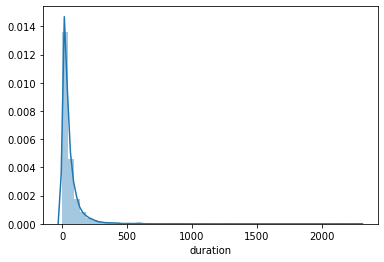

In [345]:
sns.distplot(df_train['duration'])